# Effect of different stopping criteria on the methods

*Made by Kasia Leniec and Gaspard Langlais (Subject C10)*

This notebook implements and analyzes several variants of the Dual Coordinate Descent (DCD) algorithm for training a linear SVM with L2-regularization.

We focus on comparing different **stopping criteria** and **update strategies** as proposed in the paper:
**"A Dual Coordinate Descent Method for Large-scale Linear SVM" (Hsieh et al., 2008)**

Key aspects covered:
- Four update methods: Base, Random Permutation, Online, and Shrinking
- Three stopping criteria: alpha change, projected gradient, and dual objective stabilization
- Evaluation based on accuracy, time, KKT condition violation, and primal gap

## Definition of the methods

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import numpy as np

#### Basic

In [2]:
def dcd_base(X, y, alpha, w, C, tol, it):
    D = 0
    l = len(y)

    for i in range(l):
        xi, yi = X[i], y[i]
        G = yi * np.dot(w, xi) - 1

        if alpha[i] == 0 and G >= 0:
            continue
        elif 0 < alpha[i] < np.inf and abs(G) < tol:
            continue

        Qii = np.dot(xi, xi) + D
        alpha_i_old = alpha[i]
        alpha[i] -= G / Qii
        alpha[i] = min(max(alpha[i], 0), C)
        w += (alpha[i] - alpha_i_old) * yi * xi

    return w, alpha

#### Random permutation

In [3]:
def dcd_random_perm(X, y, alpha, w, C, tol, it):
    D = 0
    l = len(y)

    for i in np.random.permutation(l):
        xi, yi = X[i], y[i]
        G = yi * np.dot(w, xi) - 1

        if alpha[i] == 0 and G >= 0:
            continue
        elif 0 < alpha[i] < np.inf and abs(G) < tol:
            continue

        Qii = np.dot(xi, xi) + D
        alpha_i_old = alpha[i]
        alpha[i] -= G / Qii
        alpha[i] = min(max(alpha[i], 0), C)
        w += (alpha[i] - alpha_i_old) * yi * xi

    return w, alpha

#### Online

In [4]:
def dcd_online(X, y, alpha, w, C, tol, it):
    D = 0
    l = len(y)

    i = np.random.randint(0, l)
    xi, yi = X[i], y[i]
    G = yi * np.dot(w, xi) - 1

    if alpha[i] == 0 and G >= 0:
        return w, alpha
    elif 0 < alpha[i] < np.inf and abs(G) < tol:
        return w, alpha

    Qii = np.dot(xi, xi) + D
    alpha_i_old = alpha[i]
    alpha[i] -= G / Qii
    alpha[i] = min(max(alpha[i], 0), C)
    w += (alpha[i] - alpha_i_old) * yi * xi

    return w, alpha

#### Shrinking

This function `dcd_with_shrinking` is directly inspired by the mechanism described in section 3.2 of the paper.

Key elements:
- Uses dynamic bounds on the projected gradient (max/min over active set)
- Removes variables that are likely to remain on bounds (KKT inactive)
- Periodically reactivates all variables to prevent freezing

In [5]:
def dcd_with_shrinking(X, y, alpha, w, C, tol, it):
    D = 0
    l, n = X.shape

    # Initialize the active set only at the first iteration
    if it == 0:
        dcd_with_shrinking.active_set = np.ones(l, dtype=bool)
        dcd_with_shrinking.shrink_counter = 0

    active_set = dcd_with_shrinking.active_set

    # Compute projected gradients for all variables
    G_proj = compute_projected_gradient(alpha, X, y, w, D, C)

    # Dynamic bounds of projected gradient on the active set
    bar_G = G_proj[active_set].max()
    under_G = G_proj[active_set].min()

    # Coordinate updates on the active variables
    for i in np.random.permutation(np.where(active_set)[0]):
        xi, yi = X[i], y[i]
        G = yi * np.dot(w, xi) - 1

        if alpha[i] == 0 and G >= 0:
            continue
        elif 0 < alpha[i] < C and abs(G) < tol:
            continue

        Qii = np.dot(xi, xi) + D
        alpha_old_i = alpha[i]
        alpha[i] -= G / Qii
        alpha[i] = min(max(alpha[i], 0), C)

        w += (alpha[i] - alpha_old_i) * yi * xi

    # Shrinking
    for i in range(l):
        if not active_set[i]:
            continue
        if alpha[i] == 0 and G_proj[i] > bar_G:
            active_set[i] = False
        elif alpha[i] == C and G_proj[i] < under_G:
            active_set[i] = False

    dcd_with_shrinking.shrink_counter += 1
    if dcd_with_shrinking.shrink_counter % 10 == 0 or np.sum(active_set) < l * 0.1:
        active_set[:] = True

    return w, alpha

#### Initialisation

In [6]:
methods = {
    "Base": dcd_base,
    "Random Permutation": dcd_random_perm,
    "Online": dcd_online,
    "With Shrinking": dcd_with_shrinking
}

## Definition of stopping criterion

In [7]:
def compute_projected_gradient(alpha, X, y, w, D, C):
    G_proj = []
    for i in range(len(alpha)):
        G = y[i] * np.dot(w, X[i]) - 1  # D is zero in L1-SVM
        if alpha[i] == 0:
            G_proj.append(min(0, G))
        elif alpha[i] == C:
            G_proj.append(max(0, G))
        else:
            G_proj.append(G)
    return np.array(G_proj)

In [8]:
def dual_objective(alpha, X, y, D):
    w = np.dot((alpha * y), X)
    loss = 0.5 * np.dot(w, w) - np.sum(alpha)
    return loss

## Verification of KKT

Allows verification of whether the final solution is truly optimal.

In [9]:
def kkt_violations(alpha, X, y, w, D, C, tol=1e-3):
    violations = 0
    for i in range(len(alpha)):
        G = y[i] * np.dot(w, X[i]) - 1  # D = 0 for L1-SVM

        if alpha[i] == 0 and G < -tol:
            violations += 1
        elif 0 < alpha[i] < C and abs(G) > tol:
            violations += 1
        elif alpha[i] == C and G > tol:
            violations += 1

    return violations / len(alpha)

## Primal experimental criterion

Allows assessment of how good the solution is, even after termination.

In [10]:
def primal_gap(w, X, y, C, fP_star):
    fP = primal_objective(w, X, y, C)
    return abs(fP - fP_star) / abs(fP_star)

Objectif function of the primal problem

In [11]:
def primal_objective(w, X, y, C):
    margins = 1 - y * (X @ w)
    hinge_loss = np.sum(np.maximum(0, margins))
    return np.dot(w, w) + C * hinge_loss

## Experimental evaluation

We test all algorithmic variants with all stopping criteria on the *Breast Cancer dataset*.

For each run, we collect:
- **Time** taken until convergence
- **Accuracy** of the resulting SVM classifier
- **Number of iterations** performed
- **Log of convergence values** (to visualize how fast the criterion decreased)
- **KKT violation rate**: measures how far the final solution is from optimality
- **Primal objective** value \( f_P(w) \)
- **Primal gap**: how close the primal value is to the best one reached among all methods

In [12]:
import time
from sklearn.metrics import accuracy_score

def evaluate_with_criteria(X, y, methods, C=1.0, tol=1e-3, max_iter=100):
    D = 1 / (2 * C)
    results = []

    for name, method in methods.items():
        for criterion_name in ['delta_alpha', 'projected_gradient', 'dual_objective']:
            alpha = np.zeros(len(y))
            w = np.zeros(X.shape[1])
            alpha_old = alpha.copy()
            f_old = dual_objective(alpha, X, y, D)
            convergence_log = [] 

            start_time = time.time()

            for it in range(max_iter):
                w, alpha = method(X, y, alpha, w, C, tol, it)

                if criterion_name == 'delta_alpha':
                    delta = np.linalg.norm(alpha - alpha_old)
                    convergence_log.append(delta)
                    if delta < tol:
                        break
                elif criterion_name == 'projected_gradient':
                    G_proj = compute_projected_gradient(alpha, X, y, w, D, C)
                    gap = G_proj.max() - G_proj.min()
                    convergence_log.append(gap)
                    if gap < tol:
                        break
                elif criterion_name == 'dual_objective':
                    f_new = dual_objective(alpha, X, y, D)
                    diff = abs(f_new - f_old)
                    convergence_log.append(diff)
                    if diff < tol:
                        break
                    f_old = f_new

                alpha_old = alpha.copy()

            elapsed = time.time() - start_time
            accuracy = accuracy_score(y, np.sign(X @ w))

            kkt_error = kkt_violations(alpha, X, y, w, D, tol)
            fP = primal_objective(w, X, y, C)
            
            results.append({
                'Method': name,
                'Criterion': criterion_name,
                'Time': elapsed,
                'Accuracy': accuracy,
                'Iterations': it + 1,
                'Log': convergence_log,
                'KKT_violation': kkt_error,
                'fP': fP # Primal function
            })

    fP_star = min(res['fP'] for res in results)
    for res in results:
        res['PrimalGap'] = abs(res['fP'] - fP_star) / abs(fP_star)

    return results

In [13]:
def display_results_table(results):
    df = pd.DataFrame(results)
    display(df)

def plot_convergence(results):
    plt.figure(figsize=(12, 6))
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    extended_colors = plt.get_cmap('tab20').colors  

    for idx, res in enumerate(results):
        label = f"{res['Method']} - {res['Criterion']}"
        iters = list(range(1, len(res['Log']) + 1))
        color = extended_colors[idx % len(extended_colors)]  
        plt.plot(iters, res['Log'], label=label, color=color, linewidth=2)

    plt.yscale('log')
    plt.xlabel("Iterations")
    plt.ylabel("Stopping criterion (log)")
    plt.title("Convergence of stopping criteria")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

,Method,Criterion,Time,Accuracy,Iterations,Log,KKT_violation,fP,PrimalGap
0,Base,delta_alpha,0.186614,0.987698,187,"[0.9026038510533022, 0.8659030964198493, 0.761...",0.000000,31.331133,0.001110
1,Base,projected_gradient,1.768108,0.987698,1000,"[13.062650773830537, 6.479482733746334, 7.8246...",0.000000,31.309293,0.000412
2,Base,dual_objective,0.125494,0.987698,126,"[3.5844301948268593, 3.822802112261043, 3.2687...",0.000000,31.525680,0.007327
3,Random Permutation,delta_alpha,0.292467,0.987698,247,"[1.004203033751191, 0.8050446489131449, 0.7713...",0.000000,31.310584,0.000454
4,Random Permutation,projected_gradient,2.162470,0.987698,1000,"[7.126375692175901, 5.325325699041496, 6.61905...",0.000000,31.296619,0.000007
5,Random Permutation,dual_objective,0.121017,0.987698,99,"[4.360483596269328, 3.8157915471282386, 3.2917...",0.000000,31.438772,0.004550
6,Online,delta_alpha,0.000112,0.947276,3,"[0.04640793900927779, 0.056700752949746525, 0.0]",0.666081,183.100501,4.850532
7,Online,projected_gradient,0.980021,0.968366,1000,"[1.5015126340641476, 3.5502926635684418, 3.165...",0.035149,51.785535,0.654681
8,Online,dual_objective,0.000103,0.861160,3,"[0.009809988045788273, 0.028909977595035115, 0.0]",0.664323,246.441906,6.874453
9,With Shrinking,delta_alpha,0.599096,0.987698,239,"[0.9115967202855062, 0.9337690083531011, 0.792...",0.000000,31.311163,0.000472


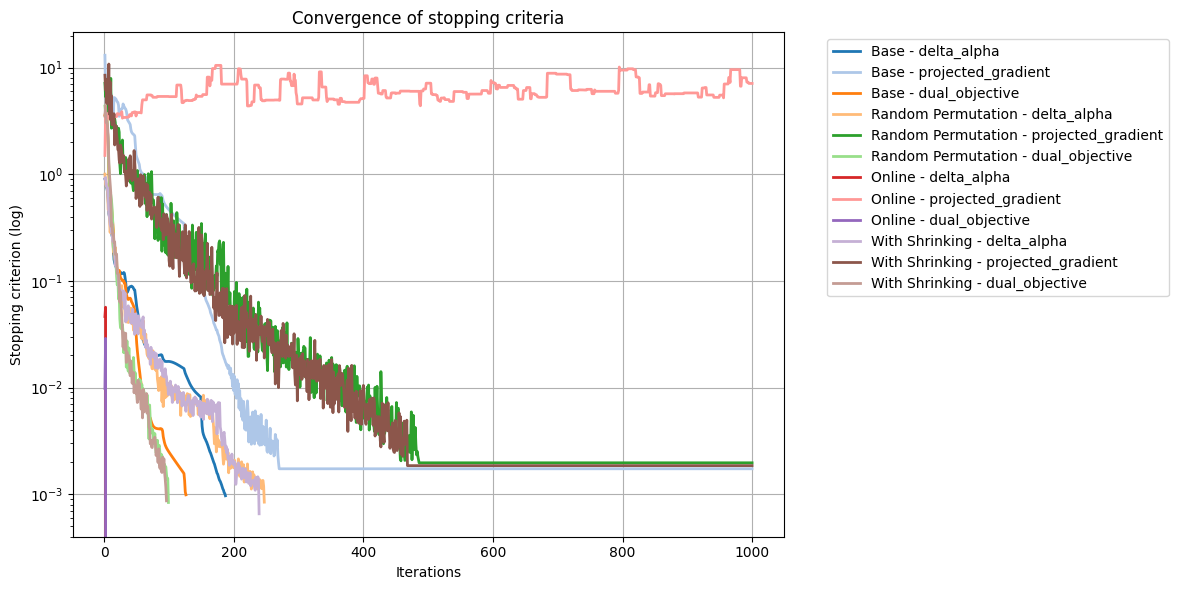

In [14]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

# Preparation
data = load_breast_cancer()
X = data.data
y = data.target
y = 2 * (y - 0.5)  # Transform labels in {-1, +1}
X = StandardScaler().fit_transform(X)

results = evaluate_with_criteria(X, y, methods, C=1.0, tol=1e-3, max_iter=1000)

display_results_table(results)
plot_convergence(results)

### How to read the results

- A **low KKT_violation** (close to 0) means that the final solution satisfies the optimality conditions (Karush-Kuhn-Tucker).
- A **low PrimalGap** means that the current solution has nearly the best primal cost among all the runs.
- If a method is **fast but has high KKT_violation or PrimalGap**, it means it stopped too early and is suboptimal.
- **Projected gradient** is the most reliable stopping criterion (but computationally expensive).
- **Dual objective** is fast but should be used with caution: it may converge prematurely.